# Workbook for Eye Tracking Data

## Import Libraries

In [36]:
# Basics
import numpy as np
import os
import math

# Data processing
import pandas as pd
import awkward as ak

# ML
import sklearn

# Misc
from pathlib import Path
import pyarrow as pa
import urllib.request

## Import data

### Import users and their score

In [37]:
# Imports the user score information
user_data = pd.read_csv(r"C:\Users\rolan\Documents\OwnCloud\10. Semester\AI Lab\eye tracking\eye-tracking\data\scores_WtG_PrePost.csv", delimiter=",", usecols=["User", "Pre score", "Post score", "Difference", "Group cat"])

In [38]:
# Defines my directory with the user data
user_dir = r'C:\Users\rolan\Documents\OwnCloud\10. Semester\AI Lab\eye tracking\eye-tracking\data\with ET'

In [39]:
# Filters and drops non-relevant users
to_drop = []
for i, cat in enumerate(user_data["Group cat"]):
    if math.isnan(cat):
        to_drop.append(i)
user_data = user_data.drop(to_drop)
user_data = user_data.reset_index(drop=True)

In [40]:
# Filters and drops users with no directory
not_existing_names = []
for i, user in enumerate(user_data["User"]):
    if not os.path.isdir(user_dir + '/' + user):
        not_existing_names.append(i)
user_data = user_data.drop(not_existing_names)
user_data = user_data.reset_index(drop=True)

In [41]:
# Convert to awkward array
array_user = ak.zip(dict(user_data))

### Import Eye Tracking data

In [42]:
# Creates dictionary with all the files for one user
file_names = {}
for user in user_data["User"]:
    #print(user)
    available_files = []
    available_files_temp = os.listdir(user_dir + '/' + user)
    for file in available_files_temp:
        if "graph01-ET_planning" in file:
            available_files.append(file)
    # print(available_files)
    file_names[user] = available_files
#file_names

In [43]:
# Read each CSV file for one user, stored for each attempt
df_attempt1 = []
df_attempt2 = []
for user in user_data['User']:
    files = file_names[user]
    if len(files) == 2:
        df_attempt1.append(pd.read_csv(user_dir + '/' + user + '/' + files[0], delimiter="	", usecols=["eyeDataTimestamp", "gazePointAOI_target_x", "gazePointAOI_target_y"]))
        df_attempt2.append(pd.read_csv(user_dir + '/' + user + '/' + files[1], delimiter="	", usecols=["eyeDataTimestamp", "gazePointAOI_target_x", "gazePointAOI_target_y"]))
    elif len(files) == 1:
        df_attempt1.append(pd.read_csv(user_dir + '/' + user + '/' + files[0], delimiter="	", usecols=["eyeDataTimestamp", "gazePointAOI_target_x", "gazePointAOI_target_y"]))
        df_attempt2.append(pd.read_csv(user_dir + '/' + user + '/' + files[0], delimiter="	", usecols=["eyeDataTimestamp", "gazePointAOI_target_x", "gazePointAOI_target_y"]))

In [44]:
# Convert df_attempts to ak.Array
array_attempt1 = []
array_attempt2 = []
for df in df_attempt1:
    array_attempt1.append(ak.Array(dict(df)))
for df in df_attempt2:
    array_attempt2.append(ak.Array(dict(df)))


## Data processing

### Add Eye Tracking Data to user data

In [45]:
def add_column_old_broken(ak_array1, ak_array2, col_name):
    entries = []
    for entry, dataframe in zip(ak_array1, ak_array2):
        entry_with_column = {**entry, col_name: dataframe}
        print(entry_with_column)
        entries.append(entry_with_column)
    print(entries)
    return ak.Array(entries)

In [46]:
def add_column_old(ak_array1, arrays, col_name):
    return ak.zip({**{k: ak_array1[k] for k in ak_array1.fields}, col_name: arrays})

In [47]:
# Adds a list of arrays in a new column to an array
def add_column(ak_array, arrays, col_name):
    combined_entries = [
        {**{k: ak_array[k][i] for k in ak_array.fields}, col_name: array} for i, (entry, array) in enumerate(zip(ak_array, arrays))
    ]
    return ak.Array(combined_entries)

In [48]:
labels_str = []
labels_int = []
for subject_name, pre_score, diff in zip(array_user["User"], array_user["Pre score"], array_user["Difference"]):
    if pre_score == 2 and diff == 0:
        label_str = "expert"
        label_int = 0   
    elif diff <= 0:
        label_str = "bad"
        label_int = 0
    else:
        label_str = "good"
        label_int = 1
    labels_str.append(label_str)
    labels_int.append(label_int)    
labels_str = ak.Array(labels_str)
labels_int = ak.Array(labels_int)



In [49]:
# Creates array with first and second attempts added as well as the labels arrays
array_data = add_column(array_user, array_attempt1, 'Attempt1')
array_data = add_column(array_data, array_attempt2, 'Attempt2')
array_data['Labels Str'] = labels_str
array_data['Labels Int'] = labels_int

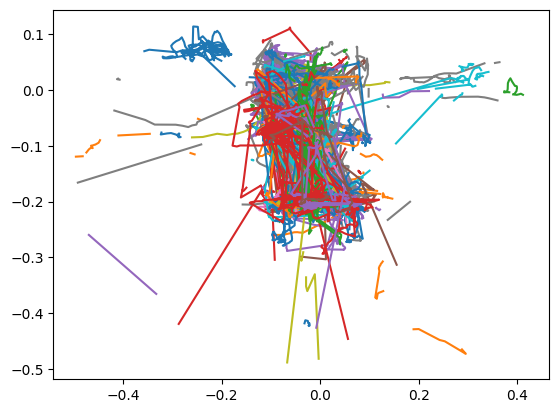

In [58]:
import matplotlib.pyplot as plt
for i, user in enumerate(array_data["User"]):
    plt.plot(array_data["Attempt1"][i]["gazePointAOI_target_x"], array_data["Attempt1"][i]["gazePointAOI_target_y"], label=user)
# plt.legend()
plt.show()